In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
import sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from tqdm import tqdm
import json
from pycocotools.mask import decode
import numpy as np
from pycocotools.mask import decode
import cv2 

np.random.seed(3)


sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device='cuda', apply_postprocessing=False)


mode = 'coco_rle'


mask_generator = SAM2AutomaticMaskGenerator(
model=sam2,
points_per_side=32,
points_per_batch=128,
pred_iou_thresh=0.5,
stability_score_thresh=0.92,
stability_score_offset=0.7,
crop_nms_thresh = 0.7,
crop_n_layers=4,
box_nms_thresh=0.4,
crop_n_points_downscale_factor=2,
min_mask_region_area=5.0,
crop_overlap_ratio= 1000 / 1500,
# use_m2m=True,
output_mode = mode,
)

In [ ]:
# Helper functions

def select_bread_mask(masks):
    area_gt = 11500
    area_diff_min = 1000000
    selected_mask = None

    for i in range(len(masks)):
        rle_annotation = masks[i]['segmentation']
        area = masks[i]['area']

        area_diff = abs(area - area_gt)
        if area_diff < area_diff_min:
            selected_mask = decode(rle_annotation)
            area_diff_min = area_diff
    
    return selected_mask

def convert_mask_to_orig_dims(cropped_mask, orig_img, crop_xmin, crop_ymin, crop_xmax, crop_ymax):
    orig_mask = np.zeros_like(orig_img[:, :, 0], dtype=np.uint8)
    orig_mask[crop_ymin:crop_ymax, crop_xmin:crop_xmax] = cropped_mask
    return orig_mask

In [13]:
dir_path = "../../data_collection/assembly/bread"
img_name = "image_20250227-005019.png"
img_path = os.path.join(dir_path, img_name)

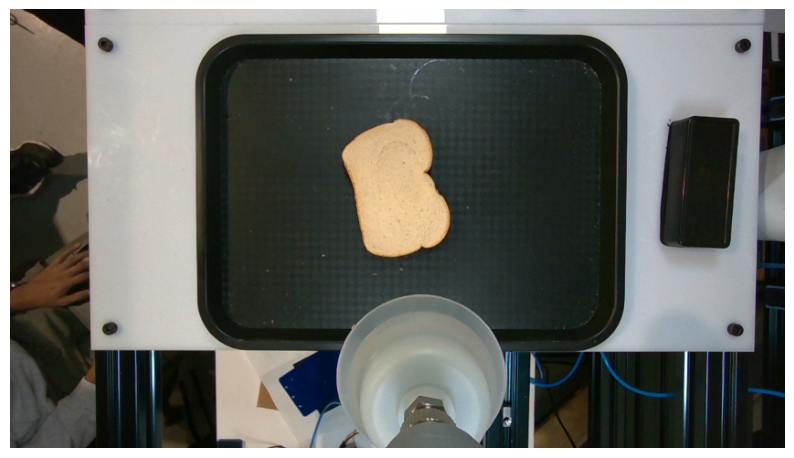

In [14]:
image = Image.open(img_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

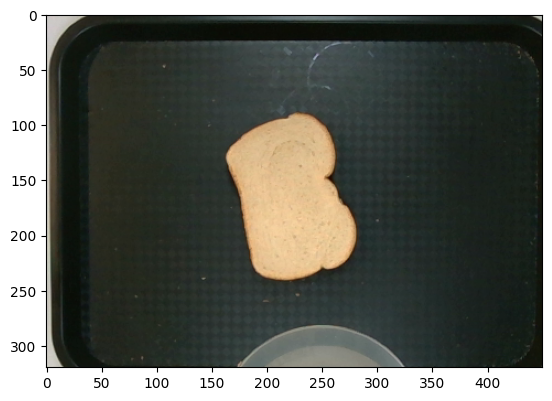

In [15]:
crop_xmin = 200
crop_ymin = 30
crop_xmax = 650
crop_ymax = 350

cropped_image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
plt.imshow(cropped_image)
plt.show()

In [16]:
masks = mask_generator.generate(cropped_image)

In [17]:
len(masks)

10

In [18]:
# valid_masks = []

# for i in range(len(masks)):
#     rle_annotation = masks[i]['segmentation']
#     rle_size = masks[i]['area']

#     if rle_size > 10000 and rle_size < 15000:    
#         binary_mask = decode(rle_annotation)
#         valid_masks.append(binary_mask)

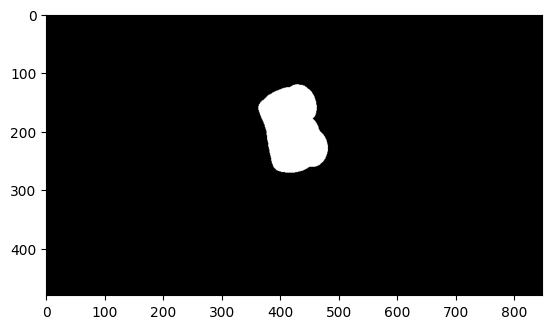

In [21]:
cropped_mask = select_bread_mask(masks)
orig_mask = convert_mask_to_orig_dims(cropped_mask, image, crop_xmin, crop_ymin, crop_xmax, crop_ymax)
orig_mask *= 255
plt.imshow(orig_mask, cmap="gray")
plt.show()

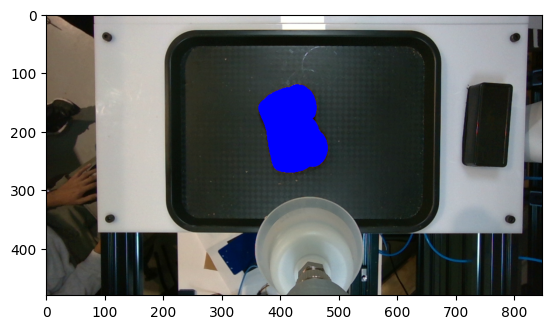

In [22]:
color = (0, 0, 255)
colored_image = np.zeros_like(image)
colored_image[:] = color

# Use the mask to blend the coloured image with the original
result = np.where(orig_mask[:, :, None] == 255, colored_image, image)

# Save or display the result
plt.imshow(result)

In [26]:
for img_name in os.listdir(dir_path):

    img_path = os.path.join(dir_path, img_name)
    image = Image.open(img_path)
    image = np.array(image.convert("RGB"))
    
    crop_xmin = 200
    crop_ymin = 30
    crop_xmax = 650
    crop_ymax = 350
    cropped_image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]

    masks = mask_generator.generate(cropped_image)

    cropped_mask = select_bread_mask(masks)
    orig_mask = convert_mask_to_orig_dims(cropped_mask, image, crop_xmin, crop_ymin, crop_xmax, crop_ymax)
    orig_mask *= 255

    color = (0, 0, 255)
    colored_image = np.zeros_like(image)
    colored_image[:] = color

    result = np.where(orig_mask[:, :, None] == 255, colored_image, image)

    cv2.imwrite(f"{img_name.split('.')[0]}_result.jpg", result)